<a href="https://colab.research.google.com/github/2017soft/AIME/blob/start-with-brac/DreamToExplore_Agent_Debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
import os
sys.argv = sys.argv[:1]
%set_env CUDA_VISIBLE_DEVICES=0
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive')
!cp /content/gdrive/My\ Drive/EIM.py /content
!cp /content/gdrive/My\ Drive/planner_regularizer_EIM.py /content
!cp -r /content/gdrive/My\ Drive/torchsample /content/
!cp /content/gdrive/My\ Drive/ObstacleData.py /content/
!python /content/gdrive/My\ Drive/setup.py build_ext --swig-opts="-modern -I../include"
!pip install tensorboardX
import torchsample
sys.path.append('/content/gdrive/My\ Drive')
import utils_planner as utils
!pip install expecttest
from tensorboardX import SummaryWriter
import torch
from EIM import ConditionalMixtureEIM, RecorderKeys, TrainIterationRecMod, ConfigInitialRecMod, DRERecMod, ComponentUpdateRecMod, WeightUpdateRecMod, Recorder

<>:16: DeprecationWarning: invalid escape sequence \ 


env: CUDA_VISIBLE_DEVICES=0
Mounted at /content/gdrive
cp: cannot open '/content/gdrive/My Drive/torchsample/setup.py.gdoc' for reading: Operation not supported
running build_ext
cythoning gsl.pyx to gsl.cpp
error: /content/gdrive/My Drive/gsl.pyx
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installing dm_control...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.5 which is incompatible.
tensorflow-metadata 1.10.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.5 which is incompatible.
tensorboardx 2.5.1 requires protobuf<=3.20.1,>=3.8.0, but you have protobuf 4.21.5 which is incompatible.
google-cloud-bigquery-storage 1.1.2 requires protobuf<4.0.0dev, but you have protobuf 4.21.5 which is incompatible.
google-api-core 1.31.6 requires protobuf<4.0.0dev,>=3.12.0; python_version > "3", but you have protobuf 4.21.5 which is incompatible.
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.7


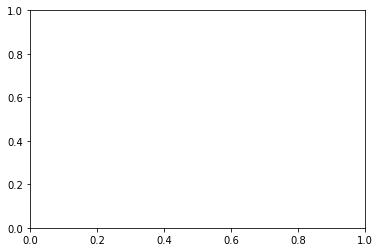

In [2]:
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
!pip install -q dm_control>=1.0.5

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")
#plotting EIM against Mojuco 
# The basic mujoco wrapper.
from dm_control import mujoco
# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib
###
import torch
import scipy.interpolate as inter
# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

# General
import copy
import os
import itertools
import numpy as np
import glob
# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from EIM import Colors, ModelRecModWithModelVis
import PIL.Image
from dm_control import mujoco
from dm_control.rl import control
from dm_control.suite import base
from dm_control.suite import common
from dm_control.utils import containers
from dm_control.utils import rewards
from dm_control.utils import io as resources
from IPython.display import HTML
import torch.utils.data as data
import re
def substringFinder(words):
    words.sort(key=lambda x:len(x))
    search = words.pop(0)
    s_len = len(search)
    for ln in range(s_len, 0, -1):
        for start in range(0, s_len-ln+1):
            cand = search[start:start+ln]
            for word in words:
                if cand not in word:
                    break
            else:
                return cand
    return False



# Use svg backend for figure rendering
fig, ax = plt.subplots()
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'myimage.svg'

fig.savefig(image_name, format=image_format, dpi=1200)


# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def display_video(frames, framerate=30, return_anim=False, filename=None):
    #https://github.com/raymond-van/planet/blob/ebe8632967ac9f638b78d6e4fc822e0740b96c86/utils.py
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    if is_notebook():
        # print("displaying in notebook")
        if return_anim:
            return anim
        else: 
            return HTML(anim.to_jshtml())
    else:
        if filename is not None:
           writervideo = animation.FFMpegWriter(fps=60) 
           anim.save(filename+".mp4", writer=writervideo)
        else:
           print("displaying in script")
           return anim

# Check if running from notebook or python script
def is_notebook():
    try:
        if os.environ.get('COLAB_NOTEBOOK_TEST', True):
            return True   # notebook
        else:
            return False # script
    except NameError:
        return False

def display_img(img):
    if type(img) == torch.Tensor:
        fig = plt.figure()
        plt.imshow(img.permute(1,2,0))
    else:
        return PIL.Image.fromarray(img)
    
# Load the environment

#cheetah, hopper, walker, swimmer, humaoid
def xyz2pixels(xyz, camera_matrix):
    """ Project 3D locations to pixel locations using the camera matrix """ 
    #https://github.com/rinuboney/FPAC/blob/b918755d9137fcfb77f2a855db1d3c661444bdf0/utils.py
    xyzs = np.ones((xyz.shape[0], xyz.shape[1]+1))
    xyzs[:, :xyz.shape[1]] = xyz
    xs, ys, s = camera_matrix.dot(xyzs.T)
    x, y = xs/s, ys/s
    return x, y

def get_positions(physics,duration):
    framerate = 60
    timevals = []
    velocity = []
    video_frames = []
    # Simulate and save data
    index_pos= physics.named.data.geom_xpos.axes.row.names
    col_names=['x', 'y', 'z']
    positions=[]
    frames = []
    physics.reset()
    while physics.data.time < duration:
      physics.step()
      timevals.append(physics.data.time)
      velocity.append(physics.data.qvel.copy())
      positions.append(physics.named.data.qpos.copy())
      data_pos=np.zeros((len(index_pos),len(col_names)))
      for index, row_name in enumerate(index_pos):
          for column, column_name in enumerate(col_names):
              data_pos[index,column]=physics.named.data.geom_xpos[row_name, column_name]
      frames.append(data_pos)
      if len(video_frames) < (physics.data.time) * framerate:
         pixels = physics.render(camera_id=1)
         video_frames.append(pixels)

    A = np.stack(frames, axis=2)
    """
    dpi = 100
    width = 480*2
    height = 640
    figsize = (width / dpi, height / dpi)
    fig = plt.figure(figsize=figsize)
    _, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi, sharex=True)
    ax[0,0].plot(timevals, angular_velocity)
    ax[0,0].set_title('velocity')
    ax[0,0].set_ylabel('meter / second')
    for i in range(len(index_pos)):
        ax[1,1].plot(timevals, A[i,0,:])
    ax[1,1].set_xlabel('time (seconds)')
    ax[1,1].set_ylabel('meters')
    _ = ax[1,1].set_title('X')
    for i in range(len(index_pos)):
        ax[0,1].plot(timevals, A[i,1,:])
    ax[0,1].set_xlabel('time (seconds)')
    ax[0,1].set_ylabel('meters')
    _ = ax[0,1].set_title('Y')
    for i in range(len(index_pos)):
        ax[1,0].plot(timevals, A[i,2,:])
    ax[1,0].set_xlabel('time (seconds)')
    ax[1,0].set_ylabel('meters')
    _ = ax[1,0].set_title('height')
    ax[1,2].plot(timevals, stem_height)
    ax[1,2].set_xlabel('time (seconds)')
    ax[1,2].set_ylabel('meters')
    _ = ax[1,2].set_title('position')
    fig.patch.set_visible(False)
    ax[0,2].axis('off')
    plt.tight_layout() 
    plt.show()   
    """
    return positions, velocity, A , display_video(video_frames, framerate)

class MujocoDataset(data.Dataset):

    def __init__(self, observation, next_observation):
        super(MujocoDataset, self).__init__()
        self.dataset1 = observation
        self.dataset2 =next_observation

    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, index):
        obs1=self.dataset1[index]
        obs2=self.dataset2[index]
        return obs1, obs2
    
class MujocoData:

    def __init__(self, observation, next_observation, num_obstacles=2, samples_per_context=None, seed=0):
        self.data =(observation, next_observation)
        self._num_obstacles = num_obstacles
        self._rng = np.random.RandomState(seed)
        self._num_obstacles = num_obstacles
        self._context_dim = 2 * num_obstacles
        self._sample_dim = 2 * num_obstacles #+ 2
        if samples_per_context is not None:
           self._samples_per_context = samples_per_context
        else:
          self._samples_per_context = observation.shape[0]//2
        mujoco_dataset=MujocoDataset(observation, next_observation)
        self.train_samples =data.DataLoader(mujoco_dataset, batch_size=observation.shape[0], shuffle=True)
        self.test_samples = data.DataLoader(mujoco_dataset, batch_size=observation.shape[0], shuffle=True)
    def get_spline(self, x):
        x_ext = np.zeros(2 * self._num_obstacles + 4, dtype=x.dtype)
        x_ext[0] = 0.0
        x_ext[1] = 0.5
        x_ext[2:-2] = (x + 1) / 2
        x_ext[-2] = 1.0
        x_ext[-1] = 0.5 #'(x[-1] + 1) / 2
        k = "quadratic" if self._num_obstacles == 1 else "cubic"
        return inter.interp1d(x_ext[::2], x_ext[1::2], kind=k)

class MujocoModelRecMod(ModelRecModWithModelVis):
      def __init__(self, mujoco_data, env_name, train_samples, test_samples, true_log_density=None, eval_fn=None,
                 test_log_iters=50, save_log_iters=50):
        super().__init__( train_samples, test_samples, true_log_density, eval_fn, test_log_iters, save_log_iters)
        self._data = mujoco_data
        self._env_name= env_name
        
      def get_model_and_assets(self):
          """Returns a tuple containing the model XML string and a dict of assets."""
          root_dir = '/home/memole/dm_control/lib/python3.8/site-packages/dm_control/suite/'
          self.environment=dict()
          for files in glob.glob(os.path.join(root_dir, '*.xml')):
              head, tail = os.path.split(files)
              x=substringFinder([self._env_name.lower(), tail])
              if not isinstance(x, bool):
                 if len(x)>=3:
                    self.environment[x]=files
          if len(self.environment)>0:
              d = max(self.environment, key=len)
              xml = resources.GetResource(self.environment[d])
              return xml, common.ASSETS
          else: 
             raise ValueError('There is no environment here.')
         
      def gt_keypoints(self, h, w):
          """ Extract 2D pixel locations of objects in the environment """
          camera_matrix = mujoco.Camera(self.physics, height=h, width=w, camera_id=1).matrix
          xyz = self.physics.named.data.geom_xpos.copy()
          """
          head_pos = self.physics.named.data.geom_xpos['head']
          head_mat = self.physics.named.data.geom_xmat['head'].reshape(3, 3)
          head_size = self.physics.named.model.geom_size['head']
          offsets = np.array([-1, 1]) * head_size[:, None]
          xyz_local = np.stack(itertools.product(*offsets)).T
          xyz_global = head_pos[:, None] + head_mat @ xyz_local   
          # # Camera matrices multiply homogenous [x, y, z, 1] vectors.
          corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
          corners_homogeneous[:3, :] = xyz_global
          uh, vh, zh = camera_matrix @ corners_homogeneous
          # x and y are in the pixel coordinate system of the head.
          xh = uh / zh
          yh = vh / zh
          max_width = physics.model.vis.global_.offwidth
          max_height = physics.model.vis.global_.offheight
          mujoco.MovableCamera(physics, height=max_height, width=max_width)
          """
          return xyz2pixels(xyz, camera_matrix)

      def _plot_model(self, model, title):
            x_plt = np.arange(0, 1, 1e-2)
            color = Colors()
            self.physics = mujoco.Physics.from_xml_string(*self.get_model_and_assets())
            contexts =[]
            pixels   =[]
            # Visualize the joint axis.
            scene_option = mujoco.wrapper.core.MjvOption()
            scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
            observation, next_observation=self._data
            with self.physics.reset_context():
               """Returns a copy of the generalized positions (system configuration)."""
               #position=physics.data.qpos[:]
               pos_size = self.physics.data.qpos[:].shape[0]
               """Returns a copy of the generalized velocities."""
               #velocity=physics.data.qvel[:]
               #observation = np.concatenate([position, velocity]).ravel()
               self.physics.data.qpos[:], self.physics.data.qvel[:] = observation[:pos_size, ...], observation[pos_size:, ...]
               pixels.append(self.physics.render(scene_option=scene_option, camera_id=1, segmentation=True))
               height, width, _ = pixels[0].shape
               """Observations consist of an OrderedDict containing one or more NumPy arrays"""
               contexts.append( self.gt_keypoints(height, width))
               self.physics.data.qpos[:], self.physics.data.qvel[:] = next_observation[:pos_size, ...], next_observation[pos_size:, ...]
               pixels.append(self.physics.render(scene_option=scene_option, camera_id=1, segmentation=True))
               contexts.append( self.gt_keypoints(height, width))
            fig, ax = plt.subplots(1, 1)
            PIL.Image.fromarray(pixels[0][:,:,0])
            for i in range(len(contexts)):
                context= contexts[i,i+1]
                lines=[]
                for k, c in enumerate(model.components):
                    m = (c.mean(context)[0] + 1) / 2
                    cov = c.covar(context)[0]
                    mx, my = m[::2], m[1::2]
                    plt.scatter(200 * mx, 100 * my, c=color(k))
                    for j in range(mx.shape[0]):
                       mean = np.array([mx[j], my[j]])
                       cov_j = cov[2 * j: 2 * (j + 1), 2 * j: 2 * (j + 1)]
                       plt_cx, plt_cy = self._draw_2d_covariance(mean, cov_j, 1, return_raw=True)
                       plt.plot(200 * plt_cx, 100 * plt_cy, c=color(k), linestyle="dotted", linewidth=2)
                    for j in range(2):
                        s = np.array(c.sample(contexts[i:i + 1]))
                        spline = self._data.get_spline(s[0])
                        l, = plt.plot(200 * x_plt, 100 * spline(x_plt), c=color(k), linewidth=1)
     
                lines.append(l)
                weights = model.gating_distribution.probabilities(context)[0]
                strs = ["{:.3f}".format(weights[j]) for j in range(model.num_components)]
                plt.legend(lines, strs, loc=1)
                plt.gca().set_axis_off()
                plt.gca().set_xlim(0, 200)
                plt.gca().set_ylim(0, 100)
            plt.savefig("EIM_out_imgs/" + re.sub(r"\s+", '-', title) + ".png")



In [3]:
from math import inf
import torch
from torch import jit
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions.normal import Normal
from torch.distributions import transforms as tT
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.testing._internal.common_utils import TestCase
from torch.autograd import Variable
from collections import Counter
import collections
from absl import logging
import numpy as np
import os
import gin
  
local_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

LOG_STD_MIN = torch.tensor(-5, dtype=torch.float64, device=local_device,requires_grad=False)

LOG_STD_MAX = torch.tensor(2 , dtype=torch.float64, device=local_device,requires_grad=False)

def get_spec_means_mags(spec):
  means = (spec.maximum + spec.minimum) / 2.0
  mags = (spec.maximum - spec.minimum) / 2.0
  means = Variable(torch.tensor(means).type(torch.FloatTensor), requires_grad=False)
  mags  = Variable(torch.tensor(mags).type(torch.FloatTensor), requires_grad=False)
  return means, mags

class Split(torch.nn.Module):
    """
    models a split in the network. works with convolutional models (not FC).
    specify out channels for the model to divide by n_parts.
    """
    def __init__(self, module, n_parts: int, dim=1):
        super().__init__()
        self._n_parts = n_parts
        self._dim = dim
        self._module = module
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(device=self.device)
    def forward(self, inputs):
        output = self._module(inputs)
        if output.ndim==1:
           result=torch.hsplit(output, self._n_parts )
        else:
           chunk_size = output.shape[self._dim] // self._n_parts
           result =torch.split(output, chunk_size, dim=self._dim)

        return result
      
###############################################
##################  Networks  #################
###############################################
class ActorNetwork(nn.Module):
  """Actor network."""

  def __init__(
      self,
      latent_spec,
      action_spec,
      fc_layer_params=(),
      ):
    super(ActorNetwork, self).__init__()
    self._action_spec = action_spec
    self._layers = nn.ModuleList()
    for hidden_size in fc_layer_params:
        if len(self._layers)==0:
           self._layers.append(nn.Linear(latent_spec.shape[0], hidden_size))
        else:
           self._layers.append(nn.Linear(hidden_size, hidden_size))
        self._layers.append(nn.ReLU())
    output_layer = nn.Linear(hidden_size,self._action_spec.shape[0] * 2)
    #output_layer = nn.LazyLinear(self._action_spec.shape[0] * 2)
    self._layers.append(output_layer)
    
    self._action_means, self._action_mags = get_spec_means_mags(
        self._action_spec)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device=self.device)

  def to(self, *args, **kwargs):
      super().to(*args, **kwargs)

  @property
  def action_spec(self):
      return self._action_spec

  def _get_outputs(self, state):
      h = state
      
      for l in nn.Sequential(*(list(self._layers.children())[:-1])):
          h = l(h)

      self._mean_logvar_layers = Split(
         self._layers[-1],
         n_parts=2,
      )
      mean, log_std = self._mean_logvar_layers(h)
      
      a_tanh_mode = torch.tanh(mean) * self._action_mags + self._action_means
      log_std = torch.tanh(log_std)
      log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)
      std = torch.exp(log_std)
      #base_distribution = torch.normal(0.0, 1.0)
      #transforms = torch.distributions.transforms.ComposeTransform([torch.distributions.transforms.AffineTransform(loc=self._action_means, scale=self._action_mag, event_dim=mean.shape[-1]), torch.nn.Tanh(),torch.distributions.transforms.AffineTransform(loc=mean, scale=std, event_dim=mean.shape[-1])])
      #a_distribution = torch.distributions.transformed_distribution.TransformedDistribution(base_distribution, transforms)
      a_distribution = TransformedDistribution(
                        base_distribution=Normal(loc=torch.full_like(mean, 0).to(device=self.device), 
                                                 scale=torch.full_like(mean, 1).to(device=self.device)), 
                        transforms=tT.ComposeTransform([
                                   tT.AffineTransform(loc=self._action_means.to(device=self.device), scale=self._action_mags.to(device=self.device), event_dim=mean.shape[-1]), 
                                   tT.TanhTransform(cache_size=1),
                                   tT.AffineTransform(loc=mean, scale=std, event_dim=mean.shape[-1])]))
      #https://www.ccoderun.ca/programming/doxygen/pytorch/classtorch_1_1distributions_1_1transformed__distribution_1_1TransformedDistribution.html
      return a_distribution, a_tanh_mode

  def get_log_density(self, state, action):
    a_dist, _ = self._get_outputs(state.to(device=self.device))
    log_density = a_dist.log_prob(action.to(device=self.device))
    return log_density

  @property
  def weights(self):
    w_list = []
    for l in self._layers:
      w_list.append(l.weight[0])
    return w_list

  def __call__(self, state):
    a_dist, a_tanh_mode = self._get_outputs(state.to(device=self.device))
    a_sample = a_dist.sample()
    log_pi_a = a_dist.log_prob(a_sample)
    return a_tanh_mode, a_sample, log_pi_a

  def sample_n(self, state, n=1):
    a_dist, a_tanh_mode = self._get_outputs(state)
    a_sample = a_dist.sample([n])
    log_pi_a = a_dist.log_prob(a_sample)
    return a_tanh_mode, a_sample, log_pi_a

  def sample(self, state):
    return self.sample_n(state, n=1)[1][0]

class CriticNetwork(nn.Module):
    """Critic Network."""
    def __init__(
      self,
      latent_spec,
      action_spec,
      fc_layer_params=(),
      ):
      super(CriticNetwork, self).__init__()
      self._action_spec = action_spec
      self._layers = nn.ModuleList()
      for hidden_size in fc_layer_params:
          if len(self._layers)==0:
              
              self._layers.append(nn.Linear(latent_spec.shape[0]+action_spec.shape[0], hidden_size))
          else:
              self._layers.append(nn.Linear(hidden_size, hidden_size))
          self._layers.append(nn.ReLU())
      output_layer = nn.Linear(hidden_size,1)
      self._layers.append(output_layer)
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.to(device=self.device)

    def forward(self, state,action):
        hidden = torch.cat([state.to(self.device),action.to(self.device)],dim=-1)
        for l in self._layers:
            hidden = l(hidden)
        return hidden

class ValueNetwork(nn.Module):
    """Value Network."""
    def __init__(
      self,
      latent_spec,
      fc_layer_params=(),
      ):
      super(ValueNetwork, self).__init__()
      self._latent_spec = latent_spec
      self._layers = nn.ModuleList()
      for hidden_size in fc_layer_params:
          if len(self._layers)==0:
              
              self._layers.append(nn.Linear(latent_spec.shape[0], hidden_size))
          else:
              self._layers.append(nn.Linear(hidden_size, hidden_size))
          self._layers.append(nn.ReLU())
      output_layer = nn.Linear(hidden_size,1)
      self._layers.append(output_layer)
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.to(device=self.device)

    def forward(self, state):
        hidden = state.to(device=self.device)
        for l in self._layers:
            hidden = l(hidden)
        return hidden

class Flags(object):

  def __init__(self, **kwargs):
    for key, val in kwargs.items():
      if kwargs.get(key) is not None:
         setattr(self, key, val)
      else:
         pass

def get_modules(model_params, observation_spec, action_spec):
  """Gets pytorch modules for Q-function, policy, and discriminator."""
  model_params, n_q_fns = model_params
  
  if len(model_params) == 1:
    model_params = tuple([model_params[0]] * 4)
  elif len(model_params) < 4:
    raise ValueError('Bad model parameters %s.' % model_params)
  def q_net_factory():
    return CriticNetwork(
        observation_spec, 
        action_spec,
        fc_layer_params=model_params[0])
  def p_net_factory():
    return ActorNetwork(
        observation_spec,
        action_spec,
        fc_layer_params=model_params[1])
  def c_net_factory():
    return CriticNetwork(
        observation_spec, 
        action_spec,
        fc_layer_params=model_params[2])
  def v_net_factory():
    return ValueNetwork(
        observation_spec, 
        fc_layer_params=model_params[3])
  modules_list = utils.Flags(
      q_net_factory=q_net_factory,
      p_net_factory=p_net_factory,
      c_net_factory=c_net_factory,
      v_net_factory=v_net_factory,
      n_q_fns=n_q_fns,
      )
  return modules_list
#######################################
################ AGENT ################
#######################################
ALPHA_MAX = 500.0
class GeneralAgent(nn.Module):
  """Tensorflow module for agent."""

  def __init__(
      self,
      modules_list=None,
      ):
    super(GeneralAgent, self).__init__()
    self._modules_list = modules_list
    self._build_modules()
    self.device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def _build_modules(self):
    pass



class AgentModule(GeneralAgent):
  """Pytorch module for BRAC dual agent."""
  def __init__(self,modules_list):
    # invoking the __init__ of the parent class
    super().__init__(modules_list)

  def _build_modules(self):
    self._q_nets = list()  
    n_q_fns = self._modules_list.n_q_fns
    for _ in range(n_q_fns):
      self._q_nets.append(
          [self._modules_list.q_net_factory(),  # Learned Q-value.
           self._modules_list.q_net_factory(),]  # Target Q-value.
          )
    self._p_net = self._modules_list.p_net_factory()
    self._c_net = self._modules_list.c_net_factory()
    self._v_net = self._modules_list.v_net_factory() #value network
    self._alpha_var = torch.tensor(1.0, requires_grad=True)
    self._alpha_entropy_var = torch.tensor(1.0, requires_grad=True)

  def get_alpha(self, alpha_max=ALPHA_MAX):
    return utils.clip_v2(
        self._alpha_var, 0.0, alpha_max)

  def get_alpha_entropy(self):
    return utils.relu_v2(self._alpha_entropy_var)

  def assign_alpha(self, alpha):
    self._alpha_var=torch.tensor(alpha, requires_grad=True)

  def assign_alpha_entropy(self, alpha):
    self._alpha_entropy_var=torch.tensor(alpha, requires_grad=True)

  @property
  def a_variables(self):
    return [self._alpha_var]

  @property
  def ae_variables(self):
    return [self._alpha_entropy_var]

  @property
  def q_nets(self):
    return self._q_nets

  @property
  def q_source_weights(self):
    q_weights = []
    for q_net, _ in self._q_nets:
      for name, param in q_net._layers.named_parameters():
          if 'weight' in name:
             q_weights += list(param)
    return q_weights

  @property
  def q_target_weights(self):
    q_weights = []
    for _, q_net in self._q_nets:
      for name, param in q_net._layers.named_parameters():
          if 'weight' in name:
             q_weights += list(param)
    return q_weights

  @property
  def q_source_variables(self):
    vars_=[]
    for q_net, _ in self._q_nets:
        for param in q_net._layers:
            if not isinstance(param, nn.ReLU):
               vars_+=list(param.parameters())
    return vars_
 
  @property
  def q_target_variables(self):
    vars_ = []
    for _, q_net in self._q_nets:
        for param in q_net._layers:
            if not isinstance(param, nn.ReLU):
               vars_+=list(param.parameters())
    return vars_

  @property
  def p_net(self):
    return self._p_net

  def p_fn(self, s):
    return self._p_net(s)

  @property
  def v_net(self):
    return self._v_net

  @property
  def v_variables(self):
    vars_ = []
    for param in self._v_net._layers:
        if not isinstance(param, nn.ReLU):
               vars_+=list(param.parameters())
    return vars_

  @property
  def v_weights(self):
    v_weights = []
    for name, param in self._v_net._layers.named_parameters():
        if 'weight' in name:
            v_weights += list(param)
    return v_weights

  @property
  def p_weights(self):
    p_weights = []
    for name, param in self._p_net._layers.named_parameters():
        if 'weight' in name:
            p_weights += list(param)
    return p_weights


  @property
  def p_variables(self):
    vars_=[]
    for param in self._p_net._layers:
        if not isinstance(param, nn.ReLU):
           vars_+=list(param.parameters())
    return vars_

  @property
  def c_net(self):
    return self._c_net

  @property
  def c_weights(self):
    c_weights = []
    for name, param in self._c_net._layers.named_parameters():
        if 'weight' in name:
            c_weights += list(param)
    return c_weights

  @property
  def c_variables(self):
    vars_=[]
    for param in self._c_net._layers:
        if not isinstance(param, nn.ReLU):
           vars_+=list(param.parameters())
    return vars_

class Agent(object):
  """Class for learning policy and interacting with environment."""

  def __init__(
      self,
      observation_spec=None,
      action_spec=None,
      time_step_spec=None,
      modules=None,
      optimizers= ((0.001, 0.5, 0.99),),
      batch_size=64,
      weight_decays=(0.5,),
      update_freq=1,
      update_rate=0.005,
      discount=0.99,
      env_name='HalfCheetah-v2',
      train_data=None,
      resume=False, 
      device=None
      ):
    self._latent_spec = observation_spec
    self._action_spec = action_spec
    self._time_step_spec = time_step_spec
    self._modules_list = modules
    self._optimizers = optimizers
    self._batch_size = batch_size
    self._weight_decays = weight_decays
    self._train_data = train_data
    self._update_freq = update_freq
    self._update_rate = update_rate
    self._discount = discount
    self._env_name = env_name
    self._resume = resume 
    if device is None:
       self.device = torch.device(
                    'cuda' if torch.cuda.is_available() else 'cpu')
    else:
       self.device=device
    
    directory = os.getcwd()
    checkpoint_dir=directory+"/run"
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
    self.checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    self._build_agent()

  def _build_agent(self):
    """Builds agent components."""
    if len(self._weight_decays) == 1:
       self._weight_decays = tuple([self._weight_decays[0]] * 4)
    self._build_fns()
    train_batch = self._get_train_batch()
    self._global_step = torch.tensor(0.0, requires_grad=False)
    self._init_vars(train_batch)
    self._build_optimizers()
    self._train_info = collections.OrderedDict()
    self._checkpointer = self._build_checkpointer()
    self._test_policies = collections.OrderedDict()
    self._build_test_policies()
    self._online_policy = self._build_online_policy()
    

  def _build_fns(self):
    self._agent_module = AgentModule(modules_list=self._modules_list)

  def _get_vars(self):
    return []

  def _build_optimizers(self):
     opt = self._optimizers[0]
     self._optimizer = torch.optim.Adam(
            self._agent_module.parameters(),
            lr= opt[0],
            betas=(opt[1], opt[2]),
        )
    

  def _build_loss(self, batch):
    raise NotImplementedError

  def _update_target_vars(self):
      #?
      # requires self._vars_learning and self._vars_target as state_dict`s
      for var_name, var_t in self._vars_target.items():
          updated_val = (self._update_rate
                    * self._vars_learning[var_name].data
                    + (1.0 - self._update_rate) * var_t.data)
          var_t.data.copy_(updated_val)

  def _build_test_policies(self):
      raise NotImplementedError

  def _build_online_policy(self):
      return None
  
  #def _random_policy_fn(self, state):
  #    return self._action_spec.sample(), None


  @property
  def test_policies(self):
    return self._test_policies

  @property
  def online_policy(self):
    return self._online_policy

  def _get_train_batch(self):
    """Samples and constructs batch of transitions."""
    batch_indices = np.random.choice(self._train_data.size, self._batch_size)
    batch_ = self._train_data.get_batch(batch_indices)
    transition_batch = batch_
    batch = dict(
        s1=transition_batch.s1,
        s2=transition_batch.s2,
        r=transition_batch.reward,
        dsc=transition_batch.discount,
        a1=transition_batch.a1,
        a2=transition_batch.a2,
        )
    return batch

            
  def _train_step(self):
      train_batch = self._get_train_batch()
      loss = self._build_loss(train_batch)
      self._optimizer.zero_grad()
      loss.backward()
      self._optimizer.step()
      self._global_step += 1
      if self._global_step % self._update_freq == 0:
          self._update_target_vars()
    

  def _init_vars(self, batch):
      pass

  def _get_source_target_vars(self):
      return [], []

  def _update_target_fns(self, source_vars, target_vars):
    utils.soft_variables_update(
        source_vars,
        target_vars,
        tau=self._update_rate)

  def print_train_info(self):
      summary_str = utils.get_summary_str(
                step=self._global_step, info=self._train_info)
      logging.info(summary_str)
    

  def write_train_summary(self, summary_writer):
    info = self._train_info
    step = self._global_step.numpy()
    utils.write_summary(summary_writer, info,step)

  def _build_checkpointer(self):
      #?save
      pass

  def _load_checkpoint(self):
      #?restore
      pass

  @property
  def global_step(self):
    return self._global_step.numpy()
  
################# Policies #################
class GaussianRandomSoftPolicy(nn.Module):
  """Adds Gaussian noise to actor's action."""

  def __init__(self, a_network, std=0.1, clip_eps=1e-3):
    super(GaussianRandomSoftPolicy, self).__init__()
    self._a_network = a_network
    self._std = std
    self._clip_eps = clip_eps
    self.device = torch.device(
                    'cuda' if torch.cuda.is_available() else 'cpu')
    self.to(device=self.device)
  def __call__(self, observation, state=()):
    action = self._a_network(observation.to(device=self.device))[1]
    noise = torch.normal(mean=torch.zeros(action.shape), std=self._std).to(device=self.device)
    action = action + noise
    spec = self._a_network.action_spec
    action = torch.clamp(action, spec.minimum + self._clip_eps,
                              spec.maximum - self._clip_eps)
    return action, state
  
class DeterministicSoftPolicy(nn.Module):
  """Returns mode of policy distribution."""

  def __init__(self, a_network):
    super(DeterministicSoftPolicy, self).__init__()
    self._a_network = a_network
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device=self.device)


  def __call__(self, latent_states):
    action = self._a_network(latent_states)[0]
    return action

class RandomSoftPolicy(nn.Module):
  """Returns sample from policy distribution."""

  def __init__(self, a_network):
    super(RandomSoftPolicy, self).__init__()
    self._a_network = a_network
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device=self.device)


  def __call__(self, latent_states):
    action = self._a_network(latent_states)[1]
    return action

class MaxQSoftPolicy(nn.Module):
  """Samples a few actions from policy, returns the one with highest Q-value."""

  def __init__(self, a_network, q_network, n=10):
    super(MaxQSoftPolicy, self).__init__()
    self._a_network = a_network
    self._q_network = q_network
    self._n = n
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)
  def __call__(self, latent_state):
    
    
    actions = self._a_network.sample_n(latent_state.to(device=self.device), self._n)[1]
    batch_size = actions.shape[-1]
    actions_ = torch.reshape(actions, [self._n * batch_size, -1])
    states_ = torch.tile(latent_state[None].to(self.device), (self._n, 1, 1))
    states_ = torch.reshape(states_, [self._n * batch_size, -1])
    qvals = self._q_network(states_, actions_)
    qvals = torch.reshape(qvals, [self._n, batch_size]).to(device=self.device)
    a_indices = torch.argmax(qvals, dim=0).to(device=self.device)
    gather_indices = torch.stack(
        [a_indices, torch.arange(batch_size, dtype=torch.int64).to(device=self.device)], dim=-1)
    action = utils.gather_nd(actions, gather_indices)
    return action
######################################################
###################### D2E Agent ##################### 
######################################################



######################Define Agent#################### 
gin.clear_config()
gin.config._REGISTRY.clear()
@gin.configurable
class D2EAgent(Agent):
  """dual agent class."""

  def __init__(
      self,
      alpha=1.0,
      alpha_max=ALPHA_MAX,
      train_alpha=False,
      value_penalty=True,
      target_divergence=0.0,
      alpha_entropy=0.0,
      train_alpha_entropy=False,
      target_entropy=None,
      EIM_config = ConditionalMixtureEIM.get_default_config(),
      divergence_name='kl',
      warm_start=2000,
      c_iter=3,
      ensemble_q_lambda=1.0,
      **kwargs):
    self._alpha = alpha
    self._alpha_max = alpha_max
    self._train_alpha = train_alpha
    self._value_penalty = value_penalty
    self._target_divergence = target_divergence
    self._divergence_name = divergence_name
    self._train_alpha_entropy = train_alpha_entropy
    self._alpha_entropy = alpha_entropy
    self._target_entropy = target_entropy
    self._EIM_config = EIM_config
    self._warm_start = warm_start
    self._c_iter = c_iter
    self._ensemble_q_lambda = ensemble_q_lambda
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    super(D2EAgent, self).__init__(**kwargs)
  def _build_fns(self):
    self._agent_module = AgentModule(modules_list=self._modules_list)
    self._q_fns = self._agent_module.q_nets
    self._p_fn = self._agent_module.p_fn
    self._c_fn = self._agent_module.c_net
    self._v_fn = self._agent_module.v_net #adding value network
    self._divergence = utils.get_divergence(
        name=self._divergence_name, 
        c=self._c_fn,
        device=self.device)
    #################################################################################################################################
    ############ Setting Up Configuration parameters of the EIM model to compute desity ratio of the transition function ############
    #################################################################################################################################
    self._EIM_config.train_epochs = 20
    print(self._latent_spec.shape)
    self._EIM_config.num_components = self._latent_spec.shape[0]//2 #number of dimension of latent space

    self._EIM_config.components_net_hidden_layers = [30, 30]
    self._EIM_config.components_batch_size = self._latent_spec.shape[0] #is it a correct batch size???
    self._EIM_config.components_num_epochs = 10
    self._EIM_config.components_net_reg_loss_fact = 0.0
    self._EIM_config.components_net_drop_prob = 0.0

    self._EIM_config.gating_net_hidden_layers = [30, 30]
    self._EIM_config.gating_batch_size = self._latent_spec.shape[0] #???
    self._EIM_config.gating_num_epochs = 10
    self._EIM_config.gating_net_reg_loss_fact = 0.0
    self._EIM_config.gating_net_drop_prob = 0.0

    self._EIM_config.dre_reg_loss_fact = 0.0005
    self._EIM_config.dre_early_stopping = True
    self._EIM_config.dre_drop_prob = 0.0
    self._EIM_config.dre_num_iters =  10
    self._EIM_config.dre_batch_size = self._latent_spec.shape[0] ###???
    self._EIM_config.dre_hidden_layers = [30, 30]
    ########################################################################################################################
    ##########################################   END of EIM cofiguration SETUP    ##########################################
    ########################################################################################################################
    self._agent_module.assign_alpha(self._alpha)
    if self._target_entropy is None:
      self._target_entropy = - self._action_spec.shape[0]
    self._get_alpha_entropy = self._agent_module.get_alpha_entropy
    self._agent_module.assign_alpha_entropy(self._alpha_entropy)

  def _get_alpha(self):
    return self._agent_module.get_alpha(
        alpha_max=self._alpha_max)

  def _get_q_vars(self):
    return self._agent_module.q_source_variables

  def _get_p_vars(self):
    return self._agent_module.p_variables

  def _get_c_vars(self):
    return self._agent_module.c_variables

  def _get_v_vars(self):
    return self._agent_module.v_variables
  
  def _get_q_weight_norm(self):
    weights = self._agent_module.q_source_weights
    norms = []
    for w in weights:
      norm = torch.sum(torch.square(w))
      norms.append(norm)
    return torch.stack(norms).sum(dim=0)

  def _get_p_weight_norm(self):
    weights = self._agent_module.p_weights
    norms = []
    for w in weights:
      norm = torch.sum(torch.square(w))
      norms.append(norm)
    return torch.stack(norms).sum(dim=0)

  def _get_c_weight_norm(self):
    weights = self._agent_module.c_weights
    norms = []
    for w in weights:
      norm = torch.sum(torch.square(w))
      norms.append(norm)
    return torch.stack(norms).sum(dim=0)

  def _get_v_weight_norm(self):
    weights = self._agent_module.v_weights
    norms = []
    for w in weights:
      norm = torch.sum(torch.square(w))
      norms.append(norm)
    return torch.stack(norms).sum(dim=0)


  def ensemble_q(self, qs):
    lambda_ = self._ensemble_q_lambda
    return (lambda_ *torch.min(qs, dim=-1).values
            + (1 - lambda_) * torch.max(qs, dim=-1).values)

  def _ensemble_q2_target(self, q2_targets):
    return self.ensemble_q(q2_targets)

  def _ensemble_q1(self, q1s):
    return self.ensemble_q(q1s)

  def _build_q_loss(self, batch):
    s1 = batch['s1']
    s2 = batch['s2']
    a1 = batch['a1']
    a2_b = batch['a2']
    r = batch['r']
    dsc = batch['dsc']
    _, a2_p, log_pi_a2_p = self._p_fn(s2.to(device=self.device))
    q2_targets = []
    q1_preds = []
    for q_fn, q_fn_target in self._q_fns:
      q2_target_ = q_fn_target(s2.to(device=self.device), a2_p)
      q1_pred = q_fn(s1.to(device=self.device), a1.to(device=self.device))
      q1_preds.append(q1_pred)
      q2_targets.append(q2_target_)
    q2_targets = torch.stack(q2_targets, dim=-1)
    q2_target = self._ensemble_q2_target(q2_targets)
    div_estimate = self._divergence.dual_estimate(
        s2.to(device=self.device), a2_p, a2_b.to(device=self.device))
    
    v2_target = q2_target - self._v_fn(s2.to(device=self.device))
    if self._value_penalty:
       v2_target = v2_target - self._get_alpha()[0] * div_estimate
    with torch.no_grad():
         q1_target = r.to(device=self.device) + dsc.to(device=self.device) * self._discount * v2_target
    q_losses = []
    for q1_pred in q1_preds:
      q_loss_ = torch.mean(torch.square(q1_pred - q1_target))
      q_losses.append(q_loss_)
    q_loss = torch.sum(torch.FloatTensor(q_losses))
    q_w_norm = self._get_q_weight_norm()
    norm_loss = self._weight_decays[0] * q_w_norm
    loss = q_loss + norm_loss

    info = collections.OrderedDict()
    info['q_loss'] = q_loss
    info['q_norm'] = q_w_norm
    info['r_mean'] = torch.mean(r)
    info['dsc_mean'] = torch.mean(dsc)
    info['q2_target_mean'] = torch.mean(q2_target)
    info['q1_target_mean'] = torch.mean(q1_target)

    return loss, info

  def _build_p_loss(self, batch):
    s = batch['s1']
    a_b = batch['a1']
    _, a_p, log_pi_a_p = self._p_fn(s)
    v1  = self._v_fn(s.to(device=self.device))
    q1s = []
    for q_fn, _ in self._q_fns:
      q1_ = q_fn(s, a_p)
      q1s.append(q1_)
    q1s = torch.stack(q1s, dim=-1)
    q1 = self._ensemble_q1(q1s)
    div_estimate = self._divergence.dual_estimate(
        s, a_p, a_b)
    q_start = torch.gt(self._global_step, self._warm_start).type(torch.float32)
    p_loss = torch.mean(
        self._get_alpha_entropy()[0] * log_pi_a_p
        + self._get_alpha()[0] * div_estimate + v1
        - q1 * q_start)
    p_w_norm = self._get_p_weight_norm()
    norm_loss = self._weight_decays[1] * p_w_norm
    loss = p_loss + norm_loss

    info = collections.OrderedDict()
    info['p_loss'] = p_loss
    info['p_norm'] = p_w_norm

    return loss, info
  def _recorder_EIM(self,batch):
      s1  = batch['s1']
      s2  = batch['s2']
      """configure experiment"""
      plot_realtime = True
      plot_save = False
      data=MujocoData(s1,s2)
      """Recording"""
      recorder_dict = {
         RecorderKeys.TRAIN_ITER: TrainIterationRecMod(),
         RecorderKeys.INITIAL: ConfigInitialRecMod(),
         RecorderKeys.MODEL: MujocoModelRecMod(data,
                                               self._env_name,
                                               train_samples=data.train_samples,
                                               test_samples=data.test_samples),
         RecorderKeys.DRE: DRERecMod(torch.from_numpy(np.asarray(data.train_samples))),
         RecorderKeys.COMPONENT_UPDATE: ComponentUpdateRecMod(plot=True, summarize=False)}
      if self._EIM_config.num_components > 1:
         recorder_dict[RecorderKeys.WEIGHTS_UPDATE] = WeightUpdateRecMod(plot=True)


      return Recorder(recorder_dict, plot_realtime=plot_realtime, save=plot_save, save_path="rec")


  def _build_v_loss(self, batch):
    s1  = batch['s1']
    a_b = batch['a1']
    s2  = batch['s2']
    _, a_p, _ = self._p_fn(s1.to(device=self.device))
    v_target = self._v_fn(s2.to(device=self.device))
    q1_target = []
    for q_fn, q_fn_target in self._q_fns:
      q1_ = q_fn_target(s1.to(device=self.device), a_b.to(device=self.device))
      q1_target.append(q1_)
    q1_target = torch.stack(q1_target, dim=-1)
    q1_target_ensemble = self.ensemble_q(q1_target)
    div_estimate = self._divergence.dual_estimate(
        s1.to(device=self.device), a_p, a_b.to(device=self.device))
    #########################
    #input_data next_state (s2) and state (s1) 
    self._EIM_model = ConditionalMixtureEIM(self._EIM_config, train_samples=(s1, s2), seed=torch.initial_seed())
    EIM_gate_res=0
    if self._EIM_model._model.num_components > 1:
       EIM_gate_res =self._EIM_model.update_gating()
    
    EIM_res = self._EIM_model.update_components()
    #Equation 20 in Dream to Explore paper
    v_loss = torch.mean(q1_target_ensemble - v_target
        - self._get_alpha()[0] * (div_estimate 
        + EIM_res + EIM_gate_res))
    v_w_norm = self._get_v_weight_norm()
    norm_loss = self._weight_decays[4] * v_w_norm
    loss = v_loss + norm_loss

    info = collections.OrderedDict()
    info['value_loss'] = v_loss
    info['vale_norm'] = v_w_norm
    return loss, info

  def _build_c_loss(self, batch):
    s = batch['s1']
    a_b = batch['a1']
    _, a_p, _ = self._p_fn(s)
    c_loss = self._divergence.dual_critic_loss(
        s, a_p, a_b)
    c_w_norm = self._get_c_weight_norm()
    norm_loss = self._weight_decays[2] * c_w_norm
    loss = c_loss + norm_loss

    info = collections.OrderedDict()
    info['c_loss'] = c_loss
    info['c_norm'] = c_w_norm

    return loss, info

  def _build_a_loss(self, batch):
    s = batch['s1']
    a_b = batch['a1']
    _, a_p, _ = self._p_fn(s)
    alpha = self._get_alpha()
    div_estimate = self._divergence.dual_estimate(
        s, a_p, a_b)
    a_loss = - torch.mean(alpha * (div_estimate - self._target_divergence))

    info = collections.OrderedDict()
    info['a_loss'] = a_loss
    info['alpha'] = alpha
    info['div_mean'] = torch.mean(div_estimate)
    info['div_std'] = torch.std(div_estimate)

    return a_loss, info

  def _build_ae_loss(self, batch):
    s = batch['s1']
    _, _, log_pi_a = self._p_fn(s)
    alpha = self._get_alpha_entropy()
    ae_loss = torch.mean(alpha * (- log_pi_a - self._target_entropy))

    info = collections.OrderedDict()
    info['ae_loss'] = ae_loss
    info['alpha_entropy'] = alpha

    return ae_loss, info

  def _get_source_target_vars(self):
    return (self._agent_module.q_source_variables,
            self._agent_module.q_target_variables)

  def _build_optimizers(self):
    opts = self._optimizers
    
    if len(opts) == 1:
      opts = tuple([opts[0]] * 4)
    elif len(opts) < 4:
      raise ValueError('Bad optimizers %s.' % opts)
      
    self._q_optimizer = torch.optim.Adam(self._get_q_vars(),lr=opts[0][0], betas=(opts[0][1],opts[0][2]), weight_decay=self._weight_decays[0])
    self._p_optimizer = torch.optim.Adam(self._get_p_vars(),lr=opts[1][0], betas=(opts[1][1],opts[1][2]), weight_decay=self._weight_decays[1])
    self._c_optimizer = torch.optim.Adam(self._get_c_vars(),lr=opts[2][0], betas=(opts[2][1],opts[2][2]), weight_decay=self._weight_decays[2])
    self._v_optimizer = torch.optim.Adam(self._get_v_vars(),lr=opts[3][0], betas=(opts[3][1],opts[3][2]), weight_decay=self._weight_decays[3])
    self._a_optimizer = torch.optim.Adam(self._a_vars, lr=opts[4][0], betas=(opts[4][1],opts[4][2]))
    self._ae_optimizer = torch.optim.Adam(self._ae_vars, lr=opts[4][0], betas=(opts[4][1],opts[4][2]))

  def _optimize_step(self, batch):
    info = collections.OrderedDict()
    if torch.equal(self._global_step % torch.tensor(self._update_freq), torch.tensor(0,dtype=torch.float32)):
      source_vars, target_vars = self._get_source_target_vars()
      self._update_target_fns(source_vars, target_vars)
    # Update policy network parameter
    #https://bit.ly/3Bno0GC
    # policy network's update should be done before updating q network, or there will make some errors
    self._agent_module.p_net.train()
    self._p_optimizer.zero_grad()
    policy_loss,_=self._build_p_loss(batch)
    policy_loss.backward(retain_graph=True)
    self._p_optimizer.step()
    # Update value network
    self._agent_module.v_net.train()
    self._v_optimizer.zero_grad()
    value_loss,_=self._build_v_loss(batch)
    value_loss.backward(retain_graph=True)
    self._v_optimizer.step()
    # Update q networks parameter
    for q_fn, q_fn_target in self._q_fns:
        q_fn.train()
        q_fn_target.train()
    self._q_optimizer.zero_grad()
    q_losses,q_info= self._build_q_loss(batch)
    q_losses.backward()
    self._q_optimizer.step()
    #Update critic network parameter
    self._agent_module.c_net.train()
    self._c_optimizer.zero_grad()
    critic_loss,_= self._build_c_loss( batch)
    critic_loss.backward()
    self._c_optimizer.step()
    #Train EIM to compute transition ratio
    self._EIM_model.train_emm()
    
    if self._train_alpha:
       self._a_optimizer.zero_grad()
       a_loss,a_info = self._build_a_loss( batch)
       a_loss.backward()
       self._a_optimizer.step()
    if self._train_alpha_entropy:
       self._ae_optimizer.zero_grad()
       ae_loss,ae_info = self._build_ae_loss( batch)
       ae_loss.backward()
       self._ae_optimizer.step()
    #1)policy loss
    info["policy_loss"]=policy_loss.cpu().item()
    #2)Q loss
    info["Q_loss"]=q_losses.cpu().item()
    info["reward_mean"]= q_info["r_mean"].cpu().item()
    info["dsc_mean"]= q_info["dsc_mean"].cpu().item()
    info["q1_target_mean"]=q_info["q1_target_mean"].cpu().item()
    info["q2_target_mean"]=q_info["q2_target_mean"].cpu().item()
        #) value loss
    info["value_loss"]= value_loss.cpu().item()
    #7) critic loss
    info["critic_loss"]=critic_loss.cpu().item()
    #8)alpha loss
    if self._train_alpha:
       info["alpha_loss"]=a_loss.cpu().item()
       self._agent_module.assign_alpha(a_info["alpha"])
    #10)alpha entropy loss
    if self._train_alpha_entropy:
       info["alpha_entropy_loss"]=ae_loss.cpu().item()
       self._agent_module.assign_alpha_entropy(ae_info["alpha_entropy"])
    return info
  
  def _extra_c_step(self, batch):
      self._c_optimizer.zero_grad()
      critic_loss,_ = self._build_c_loss( batch)
      critic_loss.backward()
      self._c_optimizer.step()

  def train_step(self):
    train_batch = self._get_train_batch()
    info = self._optimize_step(train_batch)
    for _ in range(self._c_iter - 1):
      train_batch = self._get_train_batch()
      self._extra_c_step(train_batch)
    for key, val in info.items():
      self._train_info[key] = val
    self._global_step.add(1)


  def _build_test_policies(self):
    policy = DeterministicSoftPolicy(
        a_network=self._agent_module.p_net)
    self._test_policies['main'] = policy
    policy = MaxQSoftPolicy(
        a_network=self._agent_module.p_net,
        q_network=self._agent_module.q_nets[0][0],
        )
    self._test_policies['max_q'] = policy

  def _build_online_policy(self):
    return RandomSoftPolicy(
        a_network=self._agent_module.p_net,
        )

  def _init_vars(self, batch):
    self._build_q_loss(batch)
    self._build_p_loss(batch)
    self._build_v_loss(batch)
    self._build_c_loss(batch)
    self._q_vars = self._get_q_vars()
    self._p_vars = self._get_p_vars()
    self._c_vars = self._get_c_vars()
    self._v_vars = self._get_v_vars()
    self._a_vars = self._agent_module.a_variables
    self._ae_vars = self._agent_module.ae_variables

  def _build_checkpointer(self):
      checkpoint = {
            "policy_net": self._agent_module.p_net.state_dict(),
            "critic_net": self._agent_module.c_net.state_dict(),
            "value_net" : self._agent_module.v_net.state_dict(),
            "q_optimizer": self._q_optimizer.state_dict(),
            "critic_optimizer": self._c_optimizer.state_dict(),
            "policy_optimizer": self._p_optimizer.state_dict(),
            "value_optimizer": self._v_optimizer.state_dict(),
            "train_step": self._global_step
      }
      for q_fn, q_fn_target in self._q_fns:
          checkpoint["q_net"]        = q_fn.state_dict()
          checkpoint["q_net_target"] = q_fn_target.state_dict()
      if self._train_alpha:
          checkpoint["alpha"] = self._alpha_var
          checkpoint["alpha_optimizer"] = self._a_optimizer.state_dict()
      if self._train_alpha_entropy:
          checkpoint["alpha_entropy"] = self._alpha_entropy_var
          checkpoint["alpha_entropy_optimizer"] = self._ae_optimizer.state_dict()   
      torch.save(checkpoint, self.checkpoint_path)
    
  def _load_checkpoint(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device)  # can load gpu's data on cpu machine
        for q_fn, q_fn_target in self._q_fns:
            q_fn.load_state_dict(checkpoint["q_net"])
            q_fn_target.load_state_dict(checkpoint["q_net_target"])
        self._agent_module.p_net.load_state_dict(checkpoint["policy_net"])
        self._agent_module.c_net.load_state_dict(checkpoint["critic_net"])
        self._agent_module.v_net.load_state_dict(checkpoint["value_net"])
        self._p_optimizer.load_state_dict(checkpoint["policy_optimizer1"])
        self._q_optimizer.load_state_dict(checkpoint["q_optimizer"])
        self._c_optimizer.load_state_dict(checkpoint["critic_optimizer"])
        self._v_optimizer.load_state_dict(checkpoint["value_optimizer"])
        self._global_step = checkpoint["train_step"]
        if self._train_alpha:
            self._alpha_var = checkpoint["alpha"]
            self._a_optimizer.load_state_dict(checkpoint["alpha_optimizer"])
        if self._train_alpha_entropy:
            self._alpha_entropy_var=checkpoint["alpha_entropy"]
            self._ae_optimizer.load_state_dict(checkpoint["alpha_entropy_optimizer"])
        print("load checkpoint from \"" + self.checkpoint_path +
              "\" at " + str(self._global_step) + " time step")



Fail to import hypothesis in common_utils, tests are not derandomized


In [4]:
#########################
#shorturl.at/oprZ1
#from train_eval_utils
from typing import Callable

# TODO(wuyifan): external version for loading environments
import gym
import os

# Get the prereqs
!apt-get -qq update
!apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
# Get Mujoco
!mkdir ~/.mujoco
!wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
!tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
!ls $HOME/.mujoco
!rm mujoco.tar.gz
# Add it to the actively loaded path and the bashrc path (these only do so much)
!echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin:/usr/lib/nvidia' >> "/root/.bashrc" 
!echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> "/root/.bashrc" 
# THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
!echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
!ldconfig
# Install Mujoco-py
!pip3 install -U 'mujoco-py<2.2,>=2.1'
# run once
!touch .mujoco_setup_complete
!pip install llvmlite
_mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin:/usr/lib/nvidia:/usr/local/nvidia/lib:/usr/local/nvidia/lib64'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  os.environ['MUJOCO_PY_MUJOCO_PATH'] = '/root/.mujoco/mujoco210'
  os.environ['MUJOCO_PY_MJKEY_PATH'] = '/root/.mujoco/mjkey.txt'
  !echo $PYTHONPATH
  print(sys.path)
  sys.path.insert(1, "/root/.mujoco/")
  print(sys.path)
  import mujoco_py
  _mujoco_run_once = True
###############
MJC_PATH = '/root/.mujoco'
%cd $MJC_PATH
if not os.path.exists('mujoco-py'):
  !git clone https://github.com/openai/mujoco-py.git
%cd mujoco-py
%pip install -e .

## cythonize at the first import
import mujoco_py
!pip install sk-video

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../0-libgl1-mesa-glx_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Selecting previously unselected package libglew2.0:amd64.
Preparing to unpack .../1-libglew2.0_2.0.0-5_amd64.deb ...
Unpacking libglew2.0:amd64 (2.0.0-5) ...
Selecting previously unselected package libglew-dev:amd64.
Preparing to unpack .../2-libglew-dev_2.0.0-5_amd64.deb ...
Unpacking libglew-dev:amd64 (2.0.0-5) ...
Selecting previously unselected package libglfw3:amd64.
Preparing to unpack .../3-libglfw3_3.2.1-1_amd64.deb ...
Unpacking libglfw3:amd64 (3.2.1-1) ...
Selecting previously unselected package patchelf.
Preparing to unpack .../4-patchelf_0.9-1_amd64.deb ...
Unpacking patchelf (0.9-1) ...
Selecting previously unselected package libosmesa6:amd64.
Preparing to unpack .../5-libosmesa6_20.0.8-0ubuntu1~18.0

In [6]:
from absl import app
from absl import flags
from absl import logging

import gin
import time

!pip install cnest
!pip install einops
!pip install sacred
#https://github.com/Haichao-Zhang/alf_randperm_reproduce/blob/d34cb1287a110135566afaa353ceb73faa2f3f91/alf/environments
drive.mount('/content/gdrive/')

sys.path.append('/content/gdrive/My Drive')
sys.path.insert(1, r'/content/gdrive/My Drive/data_structures')
sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')
!ls -ltr '/content/gdrive/My Drive/alf_gym_wrapper.py'
!cp /content/gdrive/My\ Drive/alf_gym_wrapper.py /content
!cp /content/gdrive/My\ Drive/alf_environment.py /content
!cp /content/gdrive/My\ Drive/data_structures.py /content
!cp /content/gdrive/My\ Drive/nest.py /content
!cp /content/gdrive/My\ Drive/tensor_specs.py /content
import alf_gym_wrapper
import importlib

def dir_path(path):
    if os.path.isdir(path):
        return path
    else:
        raise argparse.ArgumentTypeError(f"readable_dir:{path} is not a valid path")

!ls /content/gdrive/My\ Drive/offlinerl

import argparse


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for cnest: filename=cnest-1.0.4-cp37-cp37m-manylinux_2_27_x86_64.whl size=860534 sha256=8518413524ea1ba2aadb8275a8a87f23bce73e63333db8615d10b8292fa7fa6b
  Stored in directory: /root/.cache/pip/wheels/37/33/5d/1d8dd2d4742ab406f7bb0b6adf07226038d35ee1818003d993
Successfully built cnest
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 181 kB 31.1 MB/s 
     |████████████████████████████████| 99 kB 12.5 MB/s 
     |████████████████████████████████| 63 kB 2

/content/data_structures.py:51: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(default_values, collections.Mapping):


In [8]:
import collections
import numpy as np
import os
import gin
import gym
import mujoco_py
from absl import app
from absl import flags
from absl import logging
import tensor_specs
import data_structures as ds
import time
import alf_gym_wrapper
import nest
import importlib  
import imageio
import mujoco_py
from alf_environment import TimeLimit
import torch.nn as nn
import pickle
class ContinuousRandomPolicy(nn.Module):
  """Samples actions uniformly at random."""

  def __init__(self, action_spec):
    super(ContinuousRandomPolicy, self).__init__()
    self._action_spec = action_spec

  def __call__(self, observation, state=()):
    action = tensor_specs.sample_bounded_spec(
        self._action_spec, 
        #outer_dims=[observation.shape[0]]
        )
    return action, state

PolicyConfig = collections.namedtuple(
    'PolicyConfig', 'ptype, ckpt, wrapper, model_params')


PTYPES = [
   'randwalk',
    'randinit',
    'load',
]

WRAPPER_TYPES = [
    'none',
    'gaussian',
]

# params: (wrapper_type, *wrapper_params)
# wrapper_type: none, eps, gaussian, gaussianeps
#!rm -r /content/gdrive/My\ Drive/testdata/Pendulum-v0/agent_partial_target

def wrap_policy(a_net, wrapper):
  """Wraps actor network with desired randomization."""
  if wrapper[0] == 'none':
    policy = RandomSoftPolicy(a_net)
  elif wrapper[0] == 'gaussian':
    policy = GaussianRandomSoftPolicy(
        a_net, std=wrapper[1])
  return policy


def load_policy(policy_cfg, action_spec, observation_spec):
  """Loads policy based on config."""
  if policy_cfg.ptype not in PTYPES:
    raise ValueError('Unknown policy type %s.' % policy_cfg.ptype)
  if policy_cfg.ptype == 'randwalk':
    policy = ContinuousRandomPolicy(action_spec)
  elif policy_cfg.ptype in ['randinit', 'load']:
    a_net = ActorNetwork(
        observation_spec,
        action_spec,
        fc_layer_params=policy_cfg.model_params)
    if policy_cfg.ptype == 'load' and os.path.exists(policy_cfg.ckpt):
      logging.info('Loading policy from %s...', policy_cfg.ckpt)
      a_net = torch.load(policy_cfg.ckpt)
    policy = wrap_policy(a_net, policy_cfg.wrapper)
  return policy


def parse_policy_cfg(policy_cfg):
  return PolicyConfig(*policy_cfg)

def maybe_makedirs(log_dir):
  import os.path
  if not os.path.exists(log_dir):
     os.mkdir(log_dir)
#####################################
#from train_eval_utils
from typing import Callable
Transition = collections.namedtuple(
    'Transition', 's1, s2, a1, a2, discount, reward')

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from PIL import Image
#animation 
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, 
                                   fargs=(frames, patch),
                                   frames=len(frames), 
                                   repeat=repeat, interval=interval)
    
def eval_policy_episodes(env, policy, n_episodes):
  """Evaluates policy performance."""
  results = []
  
  discount=[]
  # For video / GIF.
  for ep_idx in range(n_episodes):
    time_step = env.reset()
    total_rewards = 0.0
    #env.render()
    while not time_step.is_last():

       action = policy(torch.from_numpy(time_step.observation))[0]  
       if action.ndim<1:
          time_step= env.step(action.unsqueeze(0).detach().cpu()) 
       else:  
          time_step= env.step(action.detach().cpu())
       total_rewards += time_step.reward or 0.
       #img = env.render(mode = 'rgb_array')
       #img = Image.fromarray(img,'RGB')
       #img.save('/content/gdrive/My Drive/offlinerl/data/HalfCheetah_{}.jpg'.format(ep_idx))
       results.append(total_rewards)
       discount.append(time_step.discount)
  results = torch.tensor(results)
  return torch.mean(results).to(dtype=torch.float32), torch.std(results).to(dtype=torch.float32),torch.tensor(discount).to(torch.float32)


def eval_policies(env, policies, n_episodes):
  results_episode_return = []
  infos = collections.OrderedDict()
  for name, policy in policies.items():
    mean, _ ,dsc = eval_policy_episodes(env, policy, n_episodes)
    results_episode_return.append(mean)
    infos[name] = collections.OrderedDict()
    infos[name]['episode_mean'] = mean
    infos[name]['discount'] = dsc
  results = results_episode_return
  return results, infos

def map_structure(func: Callable, structure):
    
    if not callable(func):
        raise TypeError("func must be callable, got: %s" % func)

    if isinstance(structure, list):
        return [map_structure(func, item) for item in structure]

    if isinstance(structure, dict):
        return {key: map_structure(func, structure[key]) for key in structure}

    return func(structure)


###############

MUJOCO_ENVS = [
    "Ant-v2",
    "HalfCheetah-v2",
    "Hopper-v2",
    "Humanoid-v2",
    "InvertedPendulum-v2",
    "InvertedDoublePendulum-v2",
    "Reacher-v2",
    "Swimmer-v2",
    "Walker2d-v2"
]
MUJOCO_ENVS_LENNGTH={"Ant-v2":1000,
    "HalfCheetah-v2":1000,
    "Hopper-v2":1000,
    "Humanoid-v2":1000,
    "InvertedPendulum-v2":1000,
    "InvertedDoublePendulum-v2":1000,
    "Reacher-v2":50,
    "Swimmer-v2":1000,
    "Walker2d-v2":1000,
    "Pendulum-v1":200
    }


def get_transition(time_step, next_time_step, action, next_action):
  return Transition(
      s1=time_step.observation,
      s2=next_time_step.observation,
      a1=action,
      a2=next_action,
      reward=next_time_step.reward,
      discount=next_time_step.discount)
  
class DataCollector(object):
  """Class for collecting sequence of environment experience."""

  def __init__(self, env, policy, data):
    self._env = env
    self._policy = policy
    self._data = data
    self._saved_action = None

  def collect_transition(self):
    """Collect single transition from environment."""
    time_step = self._env.current_time_step()
    if self._saved_action is None:
      self._saved_action = self._policy(torch.from_numpy(time_step.observation))[0]
    action = self._saved_action
    if action.ndim<1:
          next_time_step = self._env.step(action.unsqueeze(0).detach().cpu())
    else:
          next_time_step = self._env.step(action.detach().cpu())
    next_action = self._policy(torch.from_numpy(next_time_step.observation))[0]
    self._saved_action = next_action
    if not time_step.is_last():
      transition = get_transition(time_step, next_time_step,
                                  action, next_action)
      
      #time_step=time_step._replace(observation=np.expand_dims(time_step.observation, axis=0))

      self._data.add_transitions(transition)
      return 1
    else:
      return 0
  
#######################
def gather(params, indices, axis = None):
    if axis is None:
        axis = 0
    if axis < 0:
        axis = len(params.shape) + axis
    if axis == 0:
        return params[indices]
    elif axis == 1:
        return params[:, indices]
    elif axis == 2:
        return params[:, :, indices]
    elif axis == 3:
        return params[:,:,:, indices]

def scatter_update(tensor, indices, updates):
    tensor = torch.tensor(tensor)
    indices = torch.tensor(indices, dtype=torch.long)
    updates = torch.tensor(updates)
    tensor[indices] = updates
    return tensor
  
class DatasetView(object):
  """Interface for reading from dataset."""

  def __init__(self, dataset, indices):
    self._dataset = dataset
    self._indices = indices

  def get_batch(self, indices):
    real_indices = self._indices[indices]
    return self._dataset.get_batch(real_indices)

  @property
  def size(self):
    return self._indices.shape[0]

def save_copy(data, ckpt_name):
  """Creates a copy of the current data and save as a checkpoint."""
  new_data = Dataset(
      observation_spec=data.config['observation_spec'],
      action_spec=data.config['action_spec'],
      size=data.size,
      circular=False)
  full_batch = data.get_batch(np.arange(data.size))
  new_data.add_transitions(full_batch)
  torch.save(new_data, ckpt_name+".pt")
  
class Dataset(nn.Module):
  """Tensorflow module of dataset of transitions."""

  def __init__(
      self,
      observation_spec,
      action_spec,
      size,
      circular=True,
      ):
    super(Dataset, self).__init__()
    self._size = size
    self._circular = circular
    obs_shape = list(observation_spec.shape)
    obs_type = observation_spec.dtype
    action_shape = list(action_spec.shape)
    action_type = action_spec.dtype
    self._s1 = self._zeros([size] + obs_shape, obs_type)
    self._s2 = self._zeros([size] + obs_shape, obs_type)
    self._a1 = self._zeros([size] + action_shape, action_type)
    self._a2 = self._zeros([size] + action_shape, action_type)
    self._discount = self._zeros([size], torch.float32)
    self._reward = self._zeros([size], torch.float32)
    self._data = Transition(
        s1=self._s1, s2=self._s2, a1=self._a1, a2=self._a2,
        discount=self._discount, reward=self._reward)
    self._current_size = torch.tensor(0, dtype=torch.int32,requires_grad=False)
    self._current_idx = torch.tensor(0, dtype=torch.int32, requires_grad=False)
    self._capacity = torch.autograd.Variable(torch.tensor(self._size))
    self._config = collections.OrderedDict(
        observation_spec=observation_spec,
        action_spec=action_spec,
        size=size,
        circular=circular)

  @property
  def config(self):
    return self._config

  def create_view(self, indices):
    return DatasetView(self, indices)

  def get_batch(self, indices):
    indices = torch.LongTensor(indices)
    def get_batch_(data_):
      return gather(data_, indices)
    transition_batch = nest.map_structure(get_batch_, self._data)
    return transition_batch

  @property
  def data(self):
    return self._data

  @property
  def capacity(self):
    return self._size

  @property
  def size(self):
    return self._current_size.numpy()

  def _zeros(self, shape, dtype):
    """Create a variable initialized with zeros."""
    return torch.autograd.Variable(torch.zeros(shape, dtype = dtype))

  def add_transitions(self, transitions,):
    assert isinstance(transitions, Transition)
    for i in transitions._fields:
        attr=getattr(transitions,i)
        if torch.is_tensor(attr):
           attr=attr.detach().cpu()
        #print(torch.is_tensor(attr))
        transitions=transitions._replace(**{i:np.expand_dims(attr,axis=0)})
    #transitions=transitions._replace(s1=np.expand_dims(transitions.s1,axis=0))
    #print(f"new transition:{transitions}")
    batch_size = transitions.s1.shape[0]
    effective_batch_size = torch.minimum( torch.tensor(batch_size), torch.tensor(self._size - self._current_idx))
    indices = self._current_idx + torch.arange(effective_batch_size)
    for key in transitions._asdict().keys():
        data = getattr(self._data, key)
        batch = getattr(transitions, key)
        data[indices]= torch.tensor(batch[:effective_batch_size])
        #scatter_update(data, indices, batch[:effective_batch_size])
    # Update size and index.
    if torch.less(self._current_size, self._size):
      self._current_size+=effective_batch_size
    self._current_idx+=effective_batch_size
    if self._circular:
      if torch.greater_equal(self._current_idx, self._size):
        self._current_idx=0
#########################
#utils.py
def shuffle_indices_with_steps(n, steps=1, rand=None):
  """Randomly shuffling indices while keeping segments."""
  if steps == 0:
    return np.arange(n)
  if rand is None:
    rand = np.random
  n_segments = int(n // steps)
  n_effective = n_segments * steps
  batch_indices = rand.permutation(n_segments)
  batches = np.arange(n_effective).reshape([n_segments, steps])
  shuffled_batches = batches[batch_indices]
  shuffled_indices = np.arange(n)
  shuffled_indices[:n_effective] = shuffled_batches.reshape([-1])
  return shuffled_indices


#########################
#collect_data.py

def dir_path(path):
    if os.path.isdir(path):
        return path
    else:
        raise argparse.ArgumentTypeError(f"readable_dir:{path} is not a valid path")
import shutil
if not os.path.exists("/content/configs"):
   shutil.copytree('/content/gdrive/My Drive/configs', "/content/configs")
#shutil.copy('/content/gdrive/My Drive/configs/D2E_example.py', "/content")

if not os.path.exists('/content/gdrive/My Drive/offlinerl/data'):
  os.makedirs('/content/gdrive/My Drive/offlinerl/data')
else:
  pass

if not os.path.exists('/content/gdrive/My Drive/testdata/Pendulum-v0'):
     os.makedirs('/content/gdrive/My Drive/testdata/Pendulum-v0/')
else:
  pass

import argparse
parser = argparse.ArgumentParser(description='BRAC')
parser.add_argument('--root_offlinerl_dir', type=dir_path, default='/content/gdrive/My Drive/offlinerl/data', help='Root directory for saving data')
parser.add_argument('--sub_offlinerl_dir', type=str, default=None, help='sub directory for saving data.')
parser.add_argument('--test_srcdir', type=str, default=None, help='directory for saving test data.')
parser.add_argument('--env_name', type=str, default='HalfCheetah-v2',help = 'env name.')
parser.add_argument('--data_name', type=str, default='random', help = 'data name.')
parser.add_argument('--env_loader', type=str, default='mujoco', help = 'env loader, suite/gym.')
parser.add_argument('--config_dir', type=str, default='configs', help = 'config file dir.')
parser.add_argument('--config_file', type=str, default='d2e_pure', help = 'config file name.')
parser.add_argument('--policy_root_dir', type=str, default=None,help = 'Directory in which to find the behavior policy.')
parser.add_argument('--n_samples', type=int, default=int(1e2), help = 'number of transitions to collect.')
parser.add_argument('--n_eval_episodes', type=int, default=20, help = 'number episodes to eval each policy.')
parser.add_argument("--gin_file", type=str, default=[], nargs='*', help = 'Paths to the gin-config files.')

parser.add_argument('--gin_bindings', type=str, default=[], nargs='*', help = 'Gin binding parameters.')
args = parser.parse_args()
if not os.path.exists("/content/gdrive/My Drive/offlinerl/data/HalfCheetah-v2/example/0"):
   os.makedirs("/content/gdrive/My Drive/offlinerl/data/HalfCheetah-v2/example/0")
if not os.path.exists("/content/gdrive/My Drive/offlinerl/data/Pendulum-v1/example/0"):
   os.makedirs("/content/gdrive/My Drive/offlinerl/data/Pendulum-v1/example/0")
def get_sample_counts(n, distr):
  """Provides size of each sub-dataset based on desired distribution."""
  distr = torch.tensor(distr)
  distr = distr / torch.sum(distr)
  counts = []
  remainder = n
  for i in range(distr.shape[0] - 1):
    count = int(n * distr[i])
    remainder -= count
    counts.append(count)
  counts.append(remainder)
  return counts


def collect_n_transitions(tf_env, policy, data, n, log_freq=1000):
  """Adds desired number of transitions to dataset."""
  collector = DataCollector(tf_env, policy, data)
  time_st = time.time()
  timed_at_step = 0
  steps_collected = 0
  while steps_collected < n:
    count = collector.collect_transition()
    steps_collected += count
    if (steps_collected % log_freq == 0
        or steps_collected == n) and count > 0:
      steps_per_sec = ((steps_collected - timed_at_step)
                       / (time.time() - time_st))
      timed_at_step = steps_collected
      time_st = time.time()
      logging.info('(%d/%d) steps collected at %.4g steps/s.', steps_collected,
                   n, steps_per_sec)



def collect_data(
    log_dir,
    data_config,
    n_samples=int(1e3),
    env_name='HalfCheetah-v2',
    log_freq=int(1e2),
    n_eval_episodes=20,
    ):
  """
               **** Main function ****
  Creates dataset of transitions based on desired config.
  """
  seed=0
  torch.manual_seed(seed)
  np.random.seed(seed)
  dm_env = gym.spec(env_name).make()
  env = alf_gym_wrapper.AlfGymWrapper(dm_env, discount=0.99)
  env = TimeLimit(env, MUJOCO_ENVS_LENNGTH[env_name])
  observation_spec = env.observation_spec()
  action_spec = env.action_spec()
  

  # Initialize dataset.
  sample_sizes = list([cfg[-1] for cfg in data_config])
  
  sample_sizes = get_sample_counts(n_samples, sample_sizes)
  logging.info(", ".join(["%s" % s for s in sample_sizes]))
  data = Dataset(
        observation_spec,
        action_spec,
        n_samples,
        circular=False)
  
  # Collect data for each policy in data_config.
  time_st = time.time()
  test_results = collections.OrderedDict()
  for (policy_name, policy_cfg, _), n_transitions in zip(
      data_config, sample_sizes):
    policy_cfg = parse_policy_cfg(policy_cfg)
    policy = load_policy(policy_cfg, action_spec, observation_spec)
    logging.info('Testing policy %s...', policy_name)
    eval_mean, eval_std,_ = eval_policy_episodes(
        env, policy, n_eval_episodes)
    test_results[policy_name] = [eval_mean, eval_std]
    logging.info('Return mean %.4g, std %.4g.', eval_mean, eval_std)
    logging.info('Collecting data from policy %s...', policy_name)
    collect_n_transitions(env, policy, data, n_transitions, log_freq)
  # Save final dataset.
  assert data.size == data.capacity
  data_ckpt_name = os.path.join(log_dir, 'data_{}.pt'.format(env_name))
  torch.save([data.capacity, data.state_dict()], data_ckpt_name)
  whole_data_ckpt_name = os.path.join(log_dir, 'data_{}.pth'.format(env_name))
  with open( whole_data_ckpt_name, 'wb') as filehandler: 
    pickle.dump(data, filehandler)

  time_cost = time.time() - time_st
  logging.info('Finished: %d transitions collected, '
               'saved at %s, '
               'time cost %.4gs.', n_samples, data_ckpt_name, time_cost)


def main(args):
  logging.set_verbosity(logging.INFO)
  sub_dir = args.sub_offlinerl_dir
  log_dir = os.path.join(
      args.root_offlinerl_dir,
      args.env_name,
      args.data_name,
      sub_dir,
      )
  maybe_makedirs(log_dir)
  #print(args.config_dir)
  #print(args.n_samples)
  config_module = importlib.import_module(
      '{}.{}'.format(args.config_dir, args.config_file))
  collect_data(
      log_dir=log_dir,
      data_config=config_module.get_data_config(args.env_name,
                                                args.policy_root_dir),
      n_samples = args.n_samples,
      env_name  = args.env_name,
      n_eval_episodes=args.n_eval_episodes)

def collect_gym_data(args):
    args.sub_offlinerl_dir = '0'
    args.env_name = 'Pendulum-v1'
    args.data_name = 'example'
    args.config_file = 'D2E_example'
    data_dir = 'testdata'
    args.test_srcdir = os.getcwd()
    args.policy_root_dir = os.path.join(args.test_srcdir,
                                               data_dir)
    args.n_samples = 50000  # Short collection.
    args.n_eval_episodes = 1
    main(args)
if __name__ == "__main__":
  args = parser.parse_args(sys.argv[1:])
  collect_gym_data(args)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
INFO:absl:14285, 7142, 28573
INFO:absl:Tes

In [9]:
class AgentConfig(object):
  """Class for handling agent parameters."""

  def __init__(self, agent_flags):
    self._agent_flags = agent_flags
    self._agent_args = self._get_agent_args()

  def _get_agent_args(self):
    """Gets agent parameters associated with config."""
    agent_flags = self._agent_flags
    agent_args = Flags(
        observation_spec=agent_flags.observation_spec,
        action_spec=agent_flags.action_spec,
        optimizers=agent_flags.optimizers,
        batch_size=agent_flags.batch_size,
        weight_decays=agent_flags.weight_decays,
        update_rate=agent_flags.update_rate,
        update_freq=agent_flags.update_freq,
        discount=agent_flags.discount,
        train_data=agent_flags.train_data,
        )
    agent_args.modules = self._get_modules()
    return agent_args

  def _get_modules(self):
    raise NotImplementedError

  @property
  def agent_args(self):
    return self._agent_args
  
class Config(AgentConfig):

  def _get_modules(self):
    return get_modules(
        self._agent_flags.model_params,
        self._agent_flags.observation_spec,
        self._agent_flags.action_spec)


install deepmind control suite  

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import re
import gin
import dill

# When using Gin interactively, reregistering a function is not an error.
gin.enter_interactive_mode()
gin.clear_config()
def get_datetime():
  now = datetime.datetime.now().isoformat()
  now = re.sub(r'\D', '', now)[:-6]
  return now


@gin.configurable("train_eval_offline")
def train_eval_offline(
    # Basic args.
    log_dir,
    data_file,
    env_name='HalfCheetah-v2',
    n_train=int(1e6),
    shuffle_steps=0,
    seed=0,
    use_seed_for_data=False,
    # Train and eval args.
    total_train_steps=int(1e6),
    summary_freq=100,
    print_freq=1000,
    save_freq=int(2e4),
    eval_freq=5000,
    n_eval_episodes=20,
    # Agent args.
    model_params=(((200, 200),), 2),
    optimizers=(( 0.0001, 0.5, 0.99),),
    batch_size=256,
    weight_decays=(0.0,),
    update_freq=1,
    update_rate=0.005,
    discount=0.99,
    ):
  ###Training a policy with a fixed dataset.###
  # Create tf_env to get specs.
  dm_env = gym.spec(env_name).make()
  env = alf_gym_wrapper.AlfGymWrapper(dm_env,discount=discount)
  env = TimeLimit(env, MUJOCO_ENVS_LENNGTH[env_name])
  observation_spec = env.observation_spec()
  action_spec = env.action_spec()
  
  # Prepare data.
  logging.info('Loading data from %s ...', data_file)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
  
  data_ckpt_name = os.path.join(data_file, 'data_{}.pt'.format(env_name))
  whole_data_ckpt_name = os.path.join(data_file, 'data_{}.pth'.format(env_name))
  
  data_size, state = torch.load(data_ckpt_name, map_location=device)
  
  #full_data = Dataset(observation_spec, action_spec, data_size)
  scores = {} # scores is an empty dict already

  if os.path.getsize(whole_data_ckpt_name) > 0:       
    with open(whole_data_ckpt_name, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        scores = unpickler.load()
  
  full_data=scores
  for k, v in full_data._config.items():
        if k =='observation_spec':
          full_data._config['observation_spec']=observation_spec
        elif k=='action_spec':
          full_data._config['action_spec']=action_spec
   
  # Split data.
  n_train = min(n_train, full_data.size)
  logging.info('n_train %d.', n_train)
  if use_seed_for_data:
    rand = np.random.RandomState(seed)
  else:
    rand = np.random.RandomState(0)
  shuffled_indices = shuffle_indices_with_steps(
      n=full_data.size, steps=shuffle_steps, rand=rand)
  train_indices = shuffled_indices[:n_train]
  train_data = full_data.create_view(train_indices)

  # Create agent.
  agent_flags = Flags(
      observation_spec=observation_spec,
      action_spec=action_spec,
      model_params=model_params,
      optimizers=optimizers,
      batch_size=batch_size,
      weight_decays=weight_decays,
      update_freq=update_freq,
      update_rate=update_rate,
      discount=discount,
      env_name=env_name,
      train_data=train_data)
  agent_args = Config(agent_flags).agent_args
  agent = D2EAgent(**vars(agent_args)) #ATTENTION: Debugg ====> should it be D2EAgent here??
  agent_ckpt_name = os.path.join(log_dir, 'agent')

  # Restore agent from checkpoint if there exists one.
  if os.path.exists('{}.index'.format(agent_ckpt_name)):
    logging.info('Checkpoint found at %s.', agent_ckpt_name)
    torch.load(agent, agent_ckpt_name)

  # Train agent.
  train_summary_dir = os.path.join(log_dir, 'train')
  eval_summary_dir = os.path.join(log_dir, 'eval')
  train_summary_writer = SummaryWriter(
      logdir=train_summary_dir)
  eval_summary_writers = collections.OrderedDict()
  for policy_key in agent.test_policies.keys():
    eval_summary_writer = SummaryWriter(
        logdir=os.path.join(eval_summary_dir, policy_key))
    eval_summary_writers[policy_key] = eval_summary_writer
  eval_results = []

  time_st_total = time.time()
  time_st = time.time()
  step = agent.global_step
  timed_at_step = step
  while step < total_train_steps:
    agent.train_step()
    step = agent.global_step
    if step % summary_freq == 0 or step == total_train_steps:
      agent.write_train_summary(train_summary_writer)
    if step % print_freq == 0 or step == total_train_steps:
      agent.print_train_info()
    if step % eval_freq == 0 or step == total_train_steps:
      time_ed = time.time()
      time_cost = time_ed - time_st
      logging.info(
          'Training at %.4g steps/s.', (step - timed_at_step) / time_cost)
      eval_result, eval_infos = eval_policies(
          env, agent.test_policies, n_eval_episodes)
      eval_results.append([step] + eval_result)
      logging.info('Testing at step %d:', step)
      for policy_key, policy_info in eval_infos.items():
        logging.info(utils.get_summary_str(
            step=None, info=policy_info, prefix=policy_key+': '))
        utils.write_summary(eval_summary_writers[policy_key], policy_info, step)
      time_st = time.time()
      timed_at_step = step
    if step % save_freq == 0:
       agent.checkpoint_path=agent_ckpt_name
       agent._build_checkpointer()
       #for k,v in agent.__dict__.items():
       #   if k in ['_agent_module','_q_fns','_p_fn','_c_fn']:
       #      print(v)
       #torch.save(agent, agent_ckpt_name,pickle_protocol=pickle.HIGHEST_PROTOCOL)
       logging.info('Agent saved at %s.', agent_ckpt_name)

  agent._build_checkpointer()
  time_cost = time.time() - time_st_total
  logging.info('Training finished, time cost %.4gs.', time_cost)
  return torch.tensor(eval_results)
if not os.path.exists('/content/gdrive/My Drive/offlinerl/learn'):
  os.makedirs('/content/gdrive/My Drive/offlinerl/learn')
else:
  pass

##############################
#/content/gdrive/My Drive/offlinerl/data

###train_offline.py#/content/gdrive/My Drive/offlinerl/data/Pendulum-v1/example/0/data_Pendulum-v1.pt
parser = argparse.ArgumentParser(description='BRAC')
parser.add_argument('--data_root_offlinerl_dir', type=dir_path, default='/content/gdrive/My Drive/offlinerl/data/',
                     help='Root directory for data.')
parser.add_argument('--data_sub_offlinerl_dir',type=str, default=None, help= '')
parser.add_argument('--test_srcdir', type=str, default='/content/gdrive/My Drive', help='directory for saving test data.')
parser.add_argument('--data_name', type=str, default='eps1',help= 'data name.')
parser.add_argument('--data_file_name', type=str, default='',help= 'data checkpoint file name.')

# Flags for offline training.
parser.add_argument('--root_dir',type=dir_path, default= '/content/gdrive/My Drive/offlinerl/learn',
                    help='Root directory for writing logs/summaries/checkpoints.')
parser.add_argument('--sub_dir', type=str, default='0', help='')

parser.add_argument('--agent_name',  type=str, default='BRAC', help='agent name.')
parser.add_argument('--env_name', type=str, default='HalfCheetah-v2',help = 'env name.')
parser.add_argument('--seed', type=int, default=0, help='random seed, mainly for training samples.')
parser.add_argument('--total_train_steps', type=int, default=int(5e5), help='')
parser.add_argument('--n_eval_episodes',type=int, default= 20,help= '')
parser.add_argument('--n_train', type=int, default=int(1e6),help= '')
parser.add_argument("--gin_file", type=str, default=[], nargs='*', help = 'Paths to the gin-config files.')

parser.add_argument('--gin_bindings', type=str, default=[], nargs='*', help = 'Gin binding parameters.')
args = parser.parse_args()


def main(args):
  logging.set_verbosity(logging.INFO)
  
  # Setup data file path.
  data_dir = os.path.join(
      args.data_root_offlinerl_dir,
      args.env_name,
      args.data_name,
      args.data_sub_offlinerl_dir,
      )
  data_file = os.path.join(
      data_dir, args.data_file_name)
  logging.info('Data directory %s.', args.data_root_offlinerl_dir)
  # Setup log dir.
  if args.sub_dir == 'auto':
    sub_dir = get_datetime()
  else:
    sub_dir = args.sub_dir
  log_dir = os.path.join(
      args.data_root_offlinerl_dir,
      args.env_name,
      args.data_name,
      'n'+str(args.n_train),
      args.agent_name,
      sub_dir,
      str(args.seed),
      )
  
  if not os.path.exists(log_dir):
     os.makedirs(log_dir)
  else:
    pass
  train_eval_offline(
      log_dir=log_dir,
      data_file=data_file,
      env_name=args.env_name,
      n_train=args.n_train,
      total_train_steps=args.total_train_steps,
      n_eval_episodes=args.n_eval_episodes,
      )

def  Train_offline_brac(args):
    
    data_dir = 'offlinerl/data'
    #args.test_srcdir = os.getcwd()
    args.data_root_offlinerl_dir = os.path.join(args.test_srcdir, data_dir)
    args.data_sub_offlinerl_dir = '0'
    args.env_name = 'Pendulum-v1'
    args.data_name = 'example'
    args.agent_name = 'BRAC'
    args.gin_bindings = [
        'train_eval_offline.model_params=((200, 200),)',
        'train_eval_offline.optimizers=(("adam", 5e-4),)']
    args.n_train = 100
    args.n_eval_episodes = 20
    args.total_train_steps = 100  # Short training.
     
    main(args)  # Just test that it runs.
if __name__ == "__main__":
  #args = parser.parse_args(sys.argv[1:])
  args, unknown = parser.parse_known_args()
  gin.parse_config_files_and_bindings([], args.gin_bindings,finalize_config=False, skip_unknown=True, print_includes_and_imports=True)
  Train_offline_brac(args)
  gin.clear_config()
  gin.config._REGISTRY.clear()


INFO:absl:Data directory /content/gdrive/My Drive/offlinerl/data.
INFO:absl:Loading data from /content/gdrive/My Drive/offlinerl/data/Pendulum-v1/example/0/ ...
INFO:absl:n_train 100.


(3,)


TypeError: ignored

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py
# For security purposes, please check the contents of collect_env.py before running it.
!python collect_env.py